In [1]:
using CABLAB

INFO: Precompiling module CABLAB.

Use "(::Type{T})(...)" instead.

Use "(::Core.kwftype(Type{T}))(...)" instead.
 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in @osx_only(::Any) at ./deprecated.jl:496
 in include_from_node1(::String) at ./loading.jl:488 (repeats 2 times)
 in macro expansion; at ./none:2 [inlined]
 in anonymous at ./<missing>:?
 in eval(::Module, ::Any) at ./boot.jl:234
 in process_options(::Base.JLOptions) at ./client.jl:239
 in _start() at ./client.jl:318
while loading /Net/Groups/BGI/scratch/tschick/julia-packages/v0.5/Vega/src/render.jl, in expression starting on line 2
  likely near /Net/Groups/BGI/scratch/tschick/julia-packages/v0.5/Vega/src/render.jl:13
  likely near /Net/Groups/BGI/scratch/tschick/julia-packages/v0.5/Vega/src/render.jl:13
  likely near /Net/Groups/BGI/scratch/tschick/julia-packages/v0.5/Vega/src/render.jl:39
  likely near /Net/Groups/BGI/scratch/tschick/julia-packages/v0.5/Vega/src/render.jl:39
 in depwarn(::String, ::Symbol) at ./dep

In this study we investigate the redundancy the different variables in each pixel. Therefore we calculate a linear dimensionality reduction (PCA) and check how many dimensions are needed to explain 90% of the variance of a cube that contained originally 6 variables.  First we check out the variables from the cube and add some processors, because we want to do a global study

In [2]:
c     = Cube("/Net/Groups/BGI/scratch/fgans/cubecopy/datacube/")
vars  = ["GPP","Rg","t2m","fpar_fluxcom","TER","BurntArea"];
cdata = getCubeData(c,variable=vars);

In [3]:
addprocs(10)

10-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [4]:
CABLAB.DAT.init_DATworkers()

We perform some gapfilling, because the pca does not work with gaps

In [5]:
@time cube_filled     = mapCube(gapFillMSC,cdata);

215.978247 seconds (21.12 M allocations: 833.064 MB, 0.22% gc time)


And we calculate the anomalies

In [6]:
@time cubeanom        = mapCube(removeMSC,cube_filled)

164.702222 seconds (4.06 M allocations: 133.233 MB, 0.04% gc time)


Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2000-01-01T00:00:00 to 2010-12-27T00:00:00
Lon                 Axis with 1440 Elements from -180.0 to 179.75
Lat                 Axis with 720 Elements from 90.0 to -89.75
Variable            Axis with elements: GPP Rg t2m fpar_fluxcom TER BurntArea 


In [7]:
@everywhere using MultivariateStats
@everywhere function sufficient_dimensions{T}(xout::AbstractArray{T}, xin::AbstractArray{T}, expl_var::Float64 = 0.95)
    if mapreduce(isnan,+,0,xin)>0
        return xout[1]=NaN
    end
    npoint, nvar = size(xin)
    for i in 1:nvar
        _sum  = _ssum = zero(eltype(xin))
        for j in 1:npoint
            _sum  += xin[j,i]
            _ssum += xin[j,i]^2
        end
        _mean  = _sum / npoint
        _smean = _ssum / npoint
        _std = sqrt(_smean - _mean^2 > 0.0 ? _smean-_mean^2 : zero(typeof(_mean)))
        if _std == 0
            _std = 1.0
            #warn("zero variance in column $i")
        end
        for j in 1:npoint
            xin[j,i] -= _mean
            xin[j,i] /= _std
        end
    end
    pca = fit(PCA, xin, pratio = 0.999, method = :svd)
    xout[1]  =
        findfirst(cumsum(principalvars(pca)) / tprincipalvar(pca) .> expl_var)
    xout[1]
end 
registerDATFunction(sufficient_dimensions,(TimeAxis,VariableAxis),(),inmissing=(:nan,),outmissing=:nan,no_ocean=1)

CABLAB.DAT.DATFunction(((CABLAB.Cubes.Axes.RangeAxis{DateTime,:Time,CABLAB.Cubes.Axes.YearStepRange},CABLAB.Cubes.Axes.CategoricalAxis{String,:Variable}),),(),(),Any,(:nan,),:nan,1,true,zero,identity,"auto")

First we doe the analysis on the original cube:

In [8]:
@time qualitypca=mapCube(sufficient_dimensions,cube_filled,0.90);

 36.128707 seconds (2.77 M allocations: 133.360 MB, 0.19% gc time)


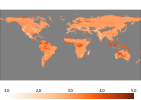

In [10]:
plotMAP(qualitypca,dmin=1.f0,dmax=5.f0)

And on the anomalies only:

In [11]:
qualitypcaanom=mapCube(sufficient_dimensions,cubeanom,0.90);

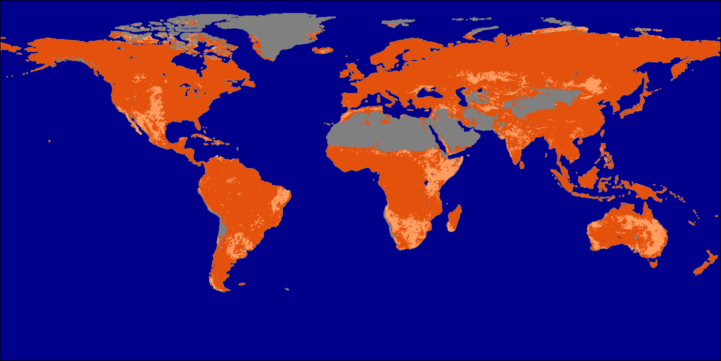

In [17]:
plotMAP(qualitypcaanom,dmin=1.f0,dmax=5.f0)